# Monitoramento

In [ ]:
#| eval: false
import dateutil
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict

In [ ]:
#| eval: false
df_abt = pd.read_csv('../datasets/abt_churn.csv', sep=';')

df_train = df_abt.query("data_ref < '2018-01-01'")
df_oot = df_abt.query("data_ref >= '2018-01-01'")

In [ ]:
#| eval: false
df_train['data_ref'].value_counts()

2017-12-01    1602
2017-11-01    1415
2017-10-01    1304
2017-09-01    1181
2017-08-01    1058
2017-07-01     946
2017-06-01     877
2017-05-01     762
2017-04-01     652
2017-03-01     490
Name: data_ref, dtype: int64

In [ ]:
#| eval: false
df_oot['data_ref'].value_counts()

2018-03-01    1874
2018-02-01    1805
2018-01-01    1690
Name: data_ref, dtype: int64

In [ ]:
#| eval: false
X_train, y_train = df_train.drop(['data_ref', 'seller_id', 'nao_revendeu_next_6m'], axis=1), df_train['nao_revendeu_next_6m']
X_oot, y_oot = df_oot.drop(['data_ref', 'seller_id', 'nao_revendeu_next_6m'], axis=1), df_oot['nao_revendeu_next_6m']

In [ ]:
#| eval: false
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(variables=['uf'])
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_oot = ohe.transform(X_oot)

In [ ]:
#| eval: false
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
auc_train = cross_validate(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)['test_score'].mean()
model.fit(X_train, y_train)
auc_oot = roc_auc_score(y_oot, model.predict_proba(X_oot)[:,1])

In [ ]:
#| eval: false
auc_train, auc_oot

(0.8732729818267317, 0.8911789919368343)

Vamos agora calcular a ROCAUC por safra:

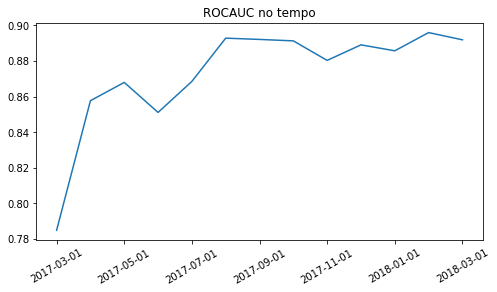

In [ ]:
#| eval: false
df_abt['proba'] = model.predict_proba(pd.concat([X_train, X_oot]))[:,1]
df_abt.groupby('data_ref').apply(lambda df_: roc_auc_score(df_['nao_revendeu_next_6m'], df_['proba'])).plot(title='ROCAUC no tempo', figsize=(8,4), rot=30, xlabel='');

# Treinando uma RF para Prever se os Dados de Produção Mudaram

Tendo as bases de produção e treinamento, podemos criar um novo target que será igual a 1 para os dados de produção e 0 para os dados de treinamento. Se um modelo classificatório conseguir prever que tipo de dado pertence ao treino ou a produção (oot), dizemos que houve potencialmente um drift populacional, indicando provavelmente que um retreino do modelo deverá ser realizado ou pelo menos remover a variável(s) que mudou de comportamento.

In [ ]:
#| eval: false
X_train['is_diff_from_train_data'] = 0
X_oot['is_diff_from_train_data'] = 1

abt_monitoramento = pd.concat([X_train, X_oot])
X_monitoramento, y_monitoramento = abt_monitoramento.drop(['is_diff_from_train_data'], axis=1), abt_monitoramento['is_diff_from_train_data']

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rocauc_cv_results = cross_validate(model, X_monitoramento, y_monitoramento, cv=5, scoring='roc_auc', n_jobs=-1)
rocauc_cv_results['test_score'].mean(), rocauc_cv_results['test_score'].std()

(0.6142722993625597, 0.055150121356693185)

Como a `ROCAUC` deu acima de 0.50, de fato houve um drift populacional. Para saber qual variável mais impactou, basta que calculemos a feature importance.

<AxesSubplot:>

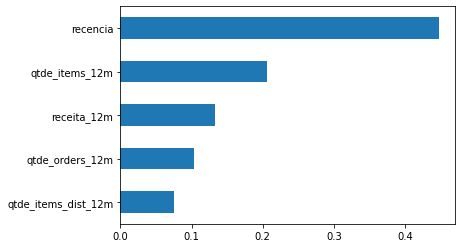

In [ ]:
#| eval: false
model.fit(X_monitoramento, y_monitoramento)
pd.Series(model.feature_importances_[:5], index=X_monitoramento.columns[:5]).sort_values(ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='Quantidade de pedidos'>

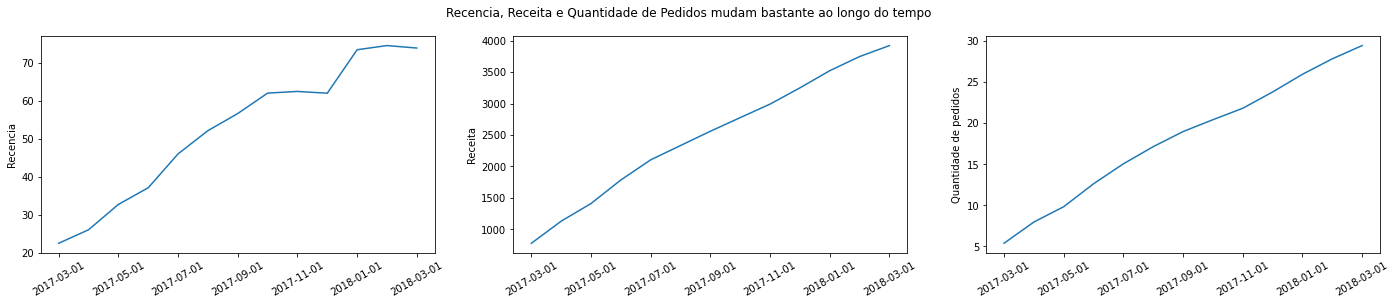

In [ ]:
#| eval: false
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,4))

fig.suptitle('Recencia, Receita e Quantidade de Pedidos mudam bastante ao longo do tempo')
df_abt.groupby('data_ref')['recencia'].mean().plot(ax=ax[0], rot=30, xlabel='', ylabel='Recencia')
df_abt.groupby('data_ref')['receita_12m'].mean().plot(ax=ax[1], rot=30, xlabel='', ylabel='Receita')
df_abt.groupby('data_ref')['qtde_orders_12m'].mean().plot(ax=ax[2], rot=30, xlabel='', ylabel='Quantidade de pedidos')

Essas 3 variáveis estão mudando bastante, mas como estão mudando de forma crescente com o tempo, muito provavelmente o modelo já absorveu esse padrão e por isso a AUC entre treino e Out of Time se mantém em torno de 0.86

# Utilizando o PSI

Population Stability Index

In [ ]:
#| eval: false
X_train = X_train.drop('is_diff_from_train_data', axis=1)
X_oot = X_oot.drop('is_diff_from_train_data', axis=1)

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

y_train_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1)[:,1]
model.fit(X_train, y_train)
y_oot_proba = model.predict_proba(X_oot)[:,1]

In [ ]:
#| eval: false
from mletrics.stability import psi

psi(y_train_proba, y_oot_proba)

0.055625999560225715

Um PSI de 0.05 indica que basicamente não houveram mudanças significativas na distribuição, como [mostrado aqui](https://joaopcnogueira.github.io/mletrics/).